In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
# Get the file
downloaded = drive.CreateFile({'id':'1uePRbSpoYH_KzlDIGGkO6wGE0LieHOq0'}) # replace the id with id of file you want to access
downloaded.GetContentFile('dataset.csv') 


In [ ]:
# Read file as panda dataframe
import pandas as pd
df= pd.read_csv('dataset.csv') 
print(df.head())

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1


In [ ]:
len(df)

50000

In [ ]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
#drop NaN valuess
df.dropna(inplace=True)

len(df)
print(df.shape)

(50000, 2)


In [ ]:
#detect and remove empty strings
empty = []  # start with an empty list

for i,rv,lb in df.itertuples():  # iterate over the DataFrame
    if type(rv)==str:            # avoid NaN values
        if rv.isspace():         # test 'review' for whitespace
            empty.append(i)     # add matching index numbers to the list
        
print(len(empty), 'empty strings: ', empty)

0 empty strings:  []


In [ ]:
#checking label counts
df['label'].value_counts()

1    25000
0    25000
Name: label, dtype: int64

In [ ]:
# output vector
y=df['label']
print(y.shape)
print(y.head())

(50000,)
0    0
1    0
2    0
3    0
4    1
Name: label, dtype: int64


In [ ]:
#input matrix
X=df.drop('label',axis=1)
print(X.shape)
print(X.head())

(50000, 1)
                                                text
0  I grew up (b. 1965) watching and loving the Th...
1  When I put this movie in my DVD player, and sa...
2  Why do people who do not know what a particula...
3  Even though I have great interest in Biblical ...
4  Im a die hard Dads Army fan and nothing will e...


In [ ]:
messages=X.copy()

In [ ]:
messages["text"][10]

"I can't believe people are looking for a plot in this film. This is Laural and Hardy. Lighten up already. These two were a riot. Their comic genius is as funny today as it was 70 years ago. Not a filthy word out of either mouth and they were able to keep audiences in stitches. Their comedy wasn't sophisticated by any stretch. If a whoopee cushion can't make you grin, there's no reason to watch any of the stuff these guys did. It was a simpler time, and people laughed at stuff that was funny without a plot. I guess it takes a simple mind to enjoy this stuff, so I qualify. Two man comedy teams don't compute, We're just too sophisticated... Aren't we fortunate?"

In [ ]:
#import nlp library for getting stop words
import nltk
import re
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Dataset Preprocessing(removing stop words and html tags and punctuations)
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print(str(i)+"  ")
    review = re.sub('[^a-zA-Z]', ' ', messages['text'][i])#replace everything excepts aphabets
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
len(corpus)

50000

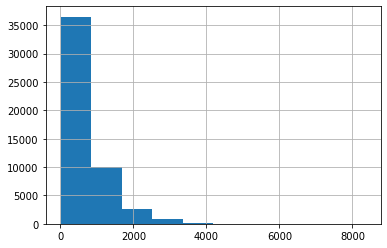

count    50000.000000
mean       732.956820
std        565.808917
min         17.000000
25%        383.000000
50%        539.000000
75%        892.000000
max       8350.000000
dtype: float64

In [ ]:
#analyse the length of the reviews
import matplotlib.pyplot as plt
%matplotlib inline
reviews_len = [len(x) for x in corpus]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [ ]:
#finding the number of reviews with reasonable length
valid_len=0
for x in corpus:
  if len(x)<1500 and len(x)>90:
    valid_len=valid_len+1
print(valid_len)


45159


In [ ]:
len(corpus)

50000

In [ ]:
#since 45,000 of the 50,000 reviews have a length less than 1500 and greater than 90 words, we will get rid of the remaining reviews(outliers)
new_corpus=[]
new_label=[]
for i in range(0,len(corpus)):
  if (len(corpus[i])<1500) and(len(corpus[i])>90):
    new_corpus.append(corpus[i])
    new_label.append(y[i])


In [ ]:
print(len(new_corpus))
print(len(new_label))

45159
45159


In [ ]:
#creating training, test and validation set on the preprocessed data 
import numpy as np
X_final=np.array(new_corpus)
y_final=np.array(new_label)
print(X_final.shape)
print(y_final.shape)

(45159,)
(45159,)


In [ ]:
#creating training set
from sklearn.model_selection import train_test_split
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X_final, y_final, test_size=0.20, random_state=7)
print(X_train.shape)
print(y_train.shape)
print(X_test_and_val.shape)
print(y_test_and_val.shape)

(36127,)
(36127,)
(9032,)
(9032,)


In [ ]:
#creating test and validation set
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size=0.50, random_state=7)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(4516,)
(4516,)
(4516,)
(4516,)


In [ ]:
#creating the ML model

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [ ]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[2025,  243],
       [ 235, 2013]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.8941541186891054

In [ ]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[2025  243]
 [ 235 2013]]


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2268
           1       0.89      0.90      0.89      2248

    accuracy                           0.89      4516
   macro avg       0.89      0.89      0.89      4516
weighted avg       0.89      0.89      0.89      4516



In [ ]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(text_clf) 

In [ ]:
# Load the pickled model 
svm_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
svm_from_pickle.predict(X_test) 

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
import pickle
pickle_out=open("svm_model.pickle","wb")
pickle.dump(text_clf,pickle_out)
pickle_out.close()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
multinomial = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Feed the training data through the pipeline
multinomial.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predictionsForMultinomialNB = multinomial.predict(X_test)

In [ ]:
accuracy_score(y_test,predictionsForMultinomialNB)

0.8682462356067316

In [ ]:
print(metrics.confusion_matrix(y_test,predictionsForMultinomialNB))

[[2036  232]
 [ 363 1885]]


In [ ]:
print(metrics.classification_report(y_test,predictionsForMultinomialNB))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2268
           1       0.89      0.84      0.86      2248

    accuracy                           0.87      4516
   macro avg       0.87      0.87      0.87      4516
weighted avg       0.87      0.87      0.87      4516

